# Transitions

This tutorial shows the apllication of spliceJAC to study cell state transitions, the change in gene regulation, and the driver genes that guide transitions. Specifically, we will cover:

- Proprocess that data and run spliceJAC
- 

We first import spliceJAC, as well as scanpy and scvelo:

In [1]:
import scvelo as scv
import scanpy as sc
import splicejac as sp

## Preparing the data for spliceJAC analysis

We will use the same pancreas endocrinogenesis dataset discussed in the GRN inference tutorial from [Bastidas-Ponce et al](https://journals.biologists.com/dev/article/146/12/dev173849/19483). We will follow the same step of the GRN inference tutorial to import and filter the data:

In [2]:
panc_data = scv.datasets.pancreas()

We filter and normalize the dataset with default parameters used on the GRN inference notebook:

In [3]:
scv.pp.filter_genes(panc_data, min_shared_counts=20)
scv.pp.normalize_per_cell(panc_data)
scv.pp.filter_genes_dispersion(panc_data, n_top_genes=2000)
scv.pp.log1p(panc_data)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


Moreover, we compute the velocity using scVelo. These calculations follow the original [scVelo tutorial](https://scvelo.readthedocs.io/VelocityBasics/), where these commands are explained in greater detail.

In [4]:
scv.tl.velocity(panc_data)
scv.tl.velocity_graph(panc_data)
panc_data.uns['neighbors']['distances'] = panc_data.obsp['distances']
panc_data.uns['neighbors']['connectivities'] = panc_data.obsp['connectivities']

computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


We will use the built-in scVelo PAGA method to identify the cell state transitionsin the data:

In [5]:
scv.tl.paga(panc_data, groups='clusters')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


We explicitly add the dataframe of PAGA-identified transition to the panc_data.uns for later use by spliceJAC:

In [6]:
panc_data.uns['PAGA_paths'] = scv.get_df(panc_data, 'paga/transitions_confidence').T

The PAGA inference highlights 7 transitions in the dataset, which can be also visualized using scVelo's built-in plotting tool.

In [7]:
panc_data.uns['PAGA_paths']

,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
Ductal,0.0,0.098458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ngn3 low EP,0.0,0.000000,0.236837,0.000000,0.000000,0.000000,0.000000,0.000000
Ngn3 high EP,0.0,0.000000,0.000000,0.247042,0.000000,0.000000,0.000000,0.000000
Pre-endocrine,0.0,0.000000,0.000000,0.000000,0.602254,0.159664,0.172915,0.117611
Beta,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Alpha,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Delta,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Epsilon,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


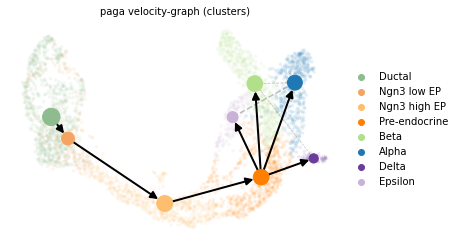

In [8]:
scv.pl.paga(panc_data, basis='umap', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

In particular, there is a linear transition from the Ductal state to Ngn3 low EP, Ngn3 high EP, to the Pre-endocrine state. Afterwards, Pre-endocrine cells follow four parallel transition paths and differentiate into Alpha, Beta, Delta and Epsilon cells, repsectively.

Finally, we run the spliceJAC inference using the same parameters discussed in the GRN inference tutorial:

In [9]:
sp.tl.estimate_jacobian(panc_data, n_top_genes=50)

Filtered out 55 genes that are detected 20 counts (shared).
Extracted 50 highly variable genes.
Running quick regression...
Running subset regression on the Ductal cluster...
Running subset regression on the Pre-endocrine cluster...
Running subset regression on the Ngn3 low EP cluster...
Running subset regression on the Epsilon cluster...
Running subset regression on the Delta cluster...
Running subset regression on the Alpha cluster...
Running subset regression on the Beta cluster...
Running subset regression on the Ngn3 high EP cluster...
